In [1]:
from __future__ import print_function
import openturns as ot
import openturns.viewer as viewer
from matplotlib import pylab as plt
ot.Log.Show(ot.Log.NONE)

In [4]:
from operator import itemgetter

# Cobweb graph

In [3]:
# Create data for an example model

# Create the model Y = x1^2 + x2
model = ot.SymbolicFunction(["x1", "x2"], ["x1^2+x2"])

# Create the input distribution and random vector X
myCorMat = ot.CorrelationMatrix(2)
myCorMat[0, 1] = -0.6
inputDist = ot.Normal([0., 0.], myCorMat)
inputDist.setDescription(['X1', 'X2'])

inputVector = ot.RandomVector(inputDist)

# Create the output random vector Y=model(X)
output = ot.CompositeRandomVector(model, inputVector)

# Generate the input sample
N = 500
X = inputVector.getSample(N)

# Evaluate the associated output sample
Y = model(X)
Y.setDescription("Y")

print(Y.getMin(), Y.getMax(), Y.computeQuantilePerComponent(0.9))

[-2.56305] [10.3512] [2.91215]


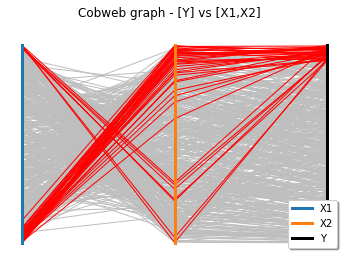

In [4]:
# Example 1: value based scale to describe the Y range

minValue = 3.35
maxValue = 20.0
quantileScale = False
graphCobweb = ot.VisualTest.DrawCobWeb(X, Y, minValue, maxValue, 'red', quantileScale)
graphCobweb.setLegendPosition('bottomright')
view = viewer.View(graphCobweb)

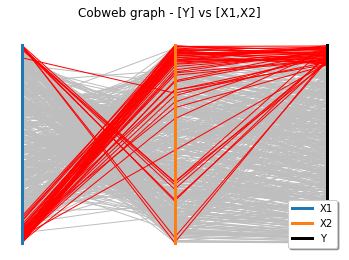

In [5]:
# Example 2: rank based scale to describe the Y range

minValue = 0.9
maxValue = 1.0
quantileScale = True
graphCobweb = ot.VisualTest.DrawCobWeb(X, Y, minValue, maxValue, 'red', quantileScale)
graphCobweb.setLegendPosition('bottomright')
view = viewer.View(graphCobweb)
plt.show()

# MC Design of experiment

In [12]:
# define the underlying distribution

distribution = ot.Normal(3)
size = 50

# create the design
experiment = ot.MonteCarloExperiment(distribution, size)
sample = experiment.generate()

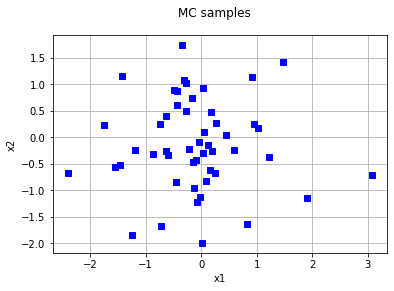

In [10]:
graph = ot.Graph("MC samples", "x1", "x2", True, "")
cloud = ot.Cloud(sample, "blue", "fsquare", "")
graph.add(cloud)
view = viewer.View(graph)
plt.show()

# Sensitivity Analysis

In [6]:
dimension = 8
input_names = ['rw', 'r', 'Tu', 'Hu', 'Tl', 'Hl', 'L', 'Kw']
model = ot.SymbolicFunction(input_names,
                            ['(2*pi_*Tu*(Hu-Hl))/(ln(r/rw)*(1+(2*L*Tu)/(ln(r/rw)*rw^2*Kw)+Tu/Tl))'])
coll = [ot.Normal(0.1, 0.0161812),
         ot.LogNormal(7.71, 1.0056),
         ot.Uniform(63070.0, 115600.0),
         ot.Uniform(990.0, 1110.0),
         ot.Uniform(63.1, 116.0),
         ot.Uniform(700.0, 820.0),
         ot.Uniform(1120.0, 1680.0),
         ot.Uniform(9855.0, 12045.0)]
distribution = ot.ComposedDistribution(coll)
distribution.setDescription(input_names)

In [7]:
selection = [1,2,4]
complement = ot.Indices(selection).complement(dimension)
distribution = distribution.getMarginal(complement)
model = ot.ParametricFunction(model, selection, distribution.getMarginal(selection).getMean())
input_names_copy = list(input_names)
input_names = itemgetter(*complement)(input_names)
dimension = len(complement)

design of experiment

In [8]:
size = 1000
X = distribution.getSample(size)
Y = model(X)

create a functional chaos model

In [9]:
algo = ot.FunctionalChaosAlgorithm(X, Y)
algo.run()
result = algo.getResult()
print(result.getResiduals())
print(result.getRelativeErrors())

[0.0164843]
[4.53595e-07]


Quick summary of sensitivity analysis

In [10]:
sensitivityAnalysis = ot.FunctionalChaosSobolIndices(result)
print(sensitivityAnalysis.summary())

 input dimension: 5
 output dimension: 1
 basis size: 40
 mean: [73.9869]
 std-dev: [27.928]
------------------------------------------------------------
Index   | Multi-indice                  | Part of variance  
------------------------------------------------------------
      1 | [1,0,0,0,0]                   | 0.652066
      3 | [0,0,1,0,0]                   | 0.0952479
      2 | [0,1,0,0,0]                   | 0.0949989
      4 | [0,0,0,1,0]                   | 0.0928278
      5 | [0,0,0,0,1]                   | 0.0232395
------------------------------------------------------------


------------------------------------------------------------
Component | Sobol index            | Sobol total index      
------------------------------------------------------------
        0 | 0.659388               | 0.688974              
        1 | 0.0950135              | 0.105966              
        2 | 0.0952506              | 0.106426              
        3 | 0.0939153              | 0.

draw Sobol’ indices

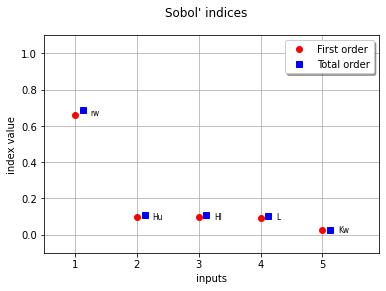

In [11]:
first_order = [sensitivityAnalysis.getSobolIndex(i) for i in range(dimension)]
total_order = [sensitivityAnalysis.getSobolTotalIndex(i) for i in range(dimension)]
graph = ot.SobolIndicesAlgorithm.DrawSobolIndices(input_names, first_order, total_order)
view = viewer.View(graph)

We saw that total order indices are close to first order, so the higher order indices must be all quite close to 0

In [12]:
for i in range(dimension):
    for j in range(i):
        print(input_names[i] + ' & '+ input_names[j], ":", sensitivityAnalysis.getSobolIndex([i, j]))

plt.show()

Hu & rw : 0.009321281096486103
Hl & rw : 0.009506103702551973
Hl & Hu : 2.3953764853609134e-05
L & rw : 0.008826276275606502
L & Hu : 0.001286079559643112
L & Hl : 0.0012895241778863459
Kw & rw : 0.0019326054272488272
Kw & Hu : 0.00032118627455836703
Kw & Hl : 0.000355513678232794
Kw & L : 0.0003306009051803717


# Estimate Sobol indices for a function with multivariate output

In [13]:
inputDistribution = ot.Normal(5)
function = ot.SymbolicFunction(['x0', 'x1', 'x2', 'x3', 'x4'],
                               ['x0 + 4.0 * x1 ^ 2 + 3.0 * x2',
                                '-7.0 * x2 - 4.0 * x3 + x4'])


In [14]:
size = 1000
sie = ot.SobolIndicesExperiment(inputDistribution, size)
inputDesign = sie.generate()
input_names = inputDistribution.getDescription()
inputDesign.setDescription(input_names)
print("Sample size: ", inputDesign.getSize())

Sample size:  7000


In [15]:
outputDesign = function(inputDesign)

In [21]:
outputDesign

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=7000 dimension=2 description=[y0,y1] data=[[-0.43324,9.60298],[-4.97724,18.6926],[12.669,-0.443831],...,[0.135497,-6.34001],[9.6466,-0.788166],[1.91629,-5.21549]]

In [20]:
print(len(inputDesign))
print(len(outputDesign))
print(size)

7000
7000
1000


In [16]:
sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)


In [17]:
output_dimension = function.getOutputDimension()
for i in range(output_dimension):
    print("Output #", i)
    first_order = sensitivityAnalysis.getFirstOrderIndices(i)
    total_order = sensitivityAnalysis.getTotalOrderIndices(i)
    print("    First order indices: ", first_order)
    print("    Total order indices: ", total_order)

agg_first_order = sensitivityAnalysis.getAggregatedFirstOrderIndices()
agg_total_order = sensitivityAnalysis.getAggregatedTotalOrderIndices()
print("Agg. first order indices: ", agg_first_order)
print("Agg. total order indices: ", agg_total_order)

Output # 0
    First order indices:  [0.0902272,0.768802,0.287855,0.0659427,0.0659427]
    Total order indices:  [0.0281965,0.662842,0.243233,-6.12686e-08,-6.12686e-08]
Output # 1
    First order indices:  [-0.0506314,-0.0506314,0.729903,0.20864,-0.034184]
    Total order indices:  [-3.05968e-07,-3.05968e-07,0.756691,0.282216,0.0127937]
Agg. first order indices:  [0.00389638,0.266579,0.558782,0.153401,0.00457604]
Agg. total order indices:  [0.0109149,0.256592,0.557926,0.172968,0.00784111]


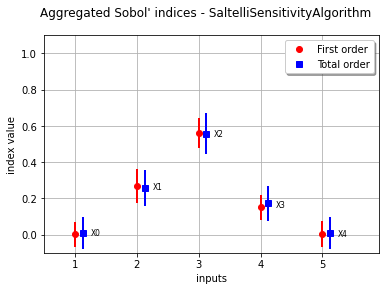

In [18]:
graph = sensitivityAnalysis.draw()
view = viewer.View(graph)